# Import libraries, load and transform data

In [2]:

!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null


In [3]:

import warnings 
warnings.filterwarnings("ignore") 

import gc 
import numpy as np  
import pandas as pd  
import itertools 
from collections import Counter  
import matplotlib.pyplot as plt 
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score,
    confusion_matrix,  
    classification_report, 
    f1_score )


# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler # import RandomUnderSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,
    Trainer, 
    ViTImageProcessor,  
    ViTForImageClassification,  
    DefaultDataCollator
)
import torch  
from torch.utils.data import DataLoader  
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose, 
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

2025-01-07 09:27:52.548646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 09:27:52.548753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 09:27:52.679406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:

from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:

from pathlib import Path
from tqdm import tqdm
import pandas as pd


file_names = []
labels = []


base_dir = Path('/kaggle/input/garbage-classification/garbage_classification/')


for file in tqdm(sorted(base_dir.glob('*/*.*'))):
    if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:  # Filter for common image formats
        file_names.append(str(file))  # Add the file path to the list
        label = file.parent.name  # Extract the label from the parent folder name
        labels.append(label)  # Add the label to the list

print(f"Total images: {len(file_names)}, Total labels: {len(labels)}, Unique labels: {len(set(labels))}")

# Create a pandas DataFrame from the collected file names and labels
df = pd.DataFrame({"image": file_names, "label": labels})


df


100%|██████████| 15515/15515 [00:00<00:00, 290273.29it/s]

Total images: 15515, Total labels: 15515, Unique labels: 12


,image,label
0,/kaggle/input/garbage-classification/garbage_c...,battery
1,/kaggle/input/garbage-classification/garbage_c...,battery
2,/kaggle/input/garbage-classification/garbage_c...,battery
3,/kaggle/input/garbage-classification/garbage_c...,battery
4,/kaggle/input/garbage-classification/garbage_c...,battery
...,...,...
15510,/kaggle/input/garbage-classification/garbage_c...,white-glass
15511,/kaggle/input/garbage-classification/garbage_c...,white-glass
15512,/kaggle/input/garbage-classification/garbage_c...,white-glass
15513,/kaggle/input/garbage-classification/garbage_c...,white-glass


In [6]:
df['label'].unique()

array(['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
       'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash',
       'white-glass'], dtype=object)

In [7]:
df['label'].value_counts().head(50)

label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64

In [8]:

labels_list = sorted(list(set(df['label'])))

In [9]:

y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(63900, 2)


In [10]:
df['label'].value_counts().head(50)

label
battery        5325
biological     5325
brown-glass    5325
cardboard      5325
clothes        5325
green-glass    5325
metal          5325
paper          5325
plastic        5325
shoes          5325
trash          5325
white-glass    5325
Name: count, dtype: int64

In [11]:

dataset = Dataset.from_pandas(df).cast_column("image", Image())

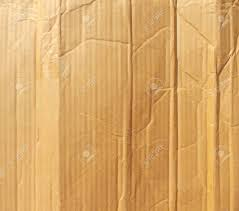

In [15]:

dataset[3297
       ]["image"]

In [16]:

labels_subset = list(df['label'])[:8]


print(labels_subset)

['battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery', 'battery']


In [17]:

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'} 

Mapping of Labels to IDs: {'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}


In [32]:
from datasets import DatasetDict, ClassLabel

# Assuming you have a DatasetDict called 'dataset'
# and a ClassLabel object called 'ClassLabels'

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Apply the mapping function
dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Access the training dataset from the DatasetDict
train_dataset = dataset['train']


split_dataset = train_dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")


train_data = split_dataset['train']
test_data = split_dataset['test']

# Output the shapes 
print("Training data shape:", train_data)
print("Testing data shape:", test_data)

Map:   0%|          | 0/38340 [00:00<?, ? examples/s]

Map:   0%|          | 0/25560 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/38340 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/25560 [00:00<?, ? examples/s]

Training data shape: Dataset({
    features: ['image', 'label'],
    num_rows: 23004
})
Testing data shape: Dataset({
    features: ['image', 'label'],
    num_rows: 15336
})


model_str = 'dima806/garbage_types_image_detection'

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        RandomHorizontalFlip(0.5),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


In [35]:

train_data.set_transform(train_transforms)

test_data.set_transform(val_transforms)

# Load, train, and evaluate model

In [36]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])
    
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [38]:

model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

85.807884


In [39]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions
    
    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids
    
    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)
    
    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [45]:
metric_name = "accuracy"

model_name = "garbage_types_image_detection"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=6e-7,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)


In [46]:


# Add the missing attribute
args.eval_use_gather_object = True  # or False, depending on your needs

# Then use these arguments in your Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [47]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.
# Create a Trainer instance for fine-tuning a language model.


trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

trainer.evaluate()

{'eval_loss': 1.0294047594070435,
 'eval_accuracy': 0.9322509128847157,
 'eval_runtime': 182.8976,
 'eval_samples_per_second': 83.85,
 'eval_steps_per_second': 1.312}

In [48]:
# Start training the model using the trainer object.

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.994551,0.933620
2,No log,0.966828,0.935707
3,0.898000,0.946221,0.937402
4,0.898000,0.934097,0.938185
5,0.898000,0.929885,0.938380


TrainOutput(global_step=900, training_loss=0.8770013088650174, metrics={'train_runtime': 3707.4177, 'train_samples_per_second': 31.024, 'train_steps_per_second': 0.243, 'total_flos': 8.91392750099841e+18, 'train_loss': 0.8770013088650174, 'epoch': 5.0})

In [49]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.92988520860672,
 'eval_accuracy': 0.9383802816901409,
 'eval_runtime': 167.0797,
 'eval_samples_per_second': 91.789,
 'eval_steps_per_second': 1.436,
 'epoch': 5.0}

In [50]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.92988520860672, 'test_accuracy': 0.9383802816901409, 'test_runtime': 159.3257, 'test_samples_per_second': 96.256, 'test_steps_per_second': 1.506}


Accuracy: 0.9384
F1 Score: 0.9369


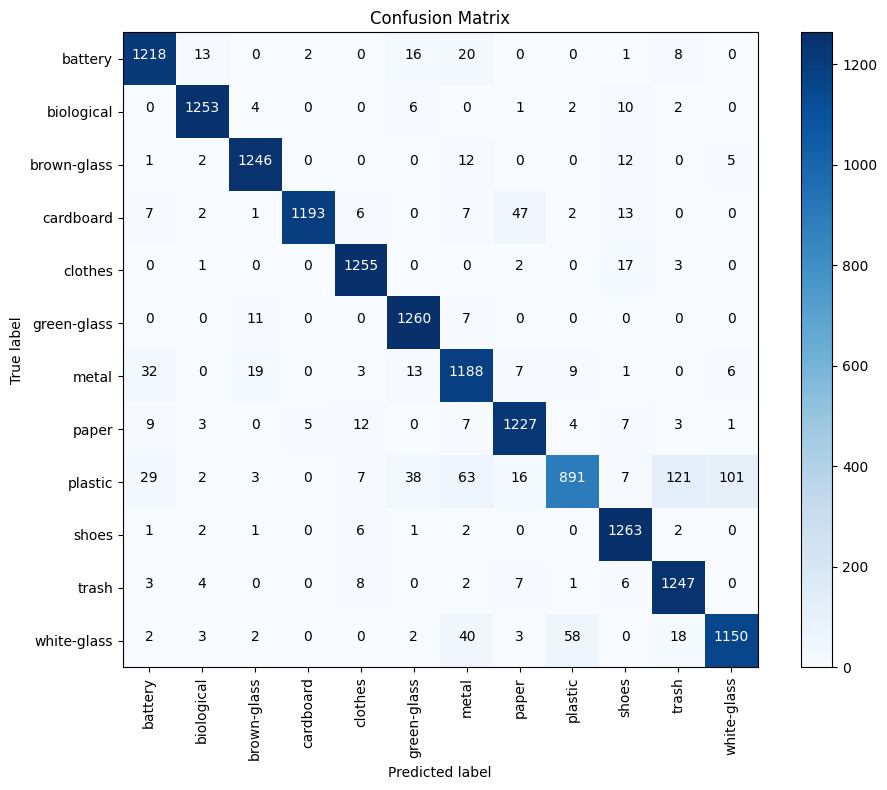


Classification report:

              precision    recall  f1-score   support

     battery     0.9355    0.9531    0.9442      1278
  biological     0.9751    0.9804    0.9778      1278
 brown-glass     0.9681    0.9750    0.9715      1278
   cardboard     0.9942    0.9335    0.9629      1278
     clothes     0.9676    0.9820    0.9748      1278
 green-glass     0.9431    0.9859    0.9640      1278
       metal     0.8813    0.9296    0.9048      1278
       paper     0.9366    0.9601    0.9482      1278
     plastic     0.9214    0.6972    0.7938      1278
       shoes     0.9447    0.9883    0.9660      1278
       trash     0.8882    0.9757    0.9299      1278
 white-glass     0.9105    0.8998    0.9052      1278

    accuracy                         0.9384     15336
   macro avg     0.9389    0.9384    0.9369     15336
weighted avg     0.9389    0.9384    0.9369     15336



In [52]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()
    
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(10, 8))
    
# Finally, display classification report
print()
print("Classification report:")
print()
try:
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
except:
    pass

In [70]:
%config HistoryManager.enabled = False


In [71]:
trainer.save_model()

In [ ]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks. 
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=1,use_fast=True)

In [ ]:
# Accessing an image from the 'test_data' dataset using index 1.
image = test_data[13445]["image"]

# Displaying the 'image' variable./
image

In [88]:
# Apply the 'pipe' function to process the 'image' variable.
pipe(image)

[{'label': 'carton', 'score': 0.9804674386978149},
 {'label': 'crate', 'score': 0.009285942651331425},
 {'label': 'packet', 'score': 0.0036577866412699223},
 {'label': 'binder, ring-binder', 'score': 0.0012006564065814018},
 {'label': 'envelope', 'score': 0.0006479723961092532}]

In [ ]:
recycling_guide = {
    "plastic": "This item is recyclable. Consider sending it to a plastic recycling facility.",
    "organic": "This is biodegradable. You can compost it to create nutrient-rich soil.",
    "metal": "This can be recycled. Take it to a scrap metal dealer or recycling center.",
    "glass": "Glass can be recycled indefinitely. Clean it and drop it off at a glass recycling bin.",
    "paper": "Paper can be recycled. Ensure it is not contaminated with food waste.",
    "electronic": "E-waste must be disposed of properly. Contact an e-waste management service."
}


In [ ]:
def chatbot_response(class_label):
    response = recycling_guide.get(class_label, "I'm not sure how to handle this object. Please consult a recycling expert.")
    return response
